# Generate point cloud and estimate normals

In [122]:
import open3d as o3d
import numpy as np
import random

In [123]:
coords = np.load("1pgb_A_predcoords.npy")
features = np.load("1pgb_A_predfeatures_emb1.npy")


In [124]:
#create an instance of PointCloud and add the points
pointcloud = o3d.geometry.PointCloud()
pointcloud.points = o3d.utility.Vector3dVector(coords)

#visualize
#o3d.visualization.draw_geometries([pointcloud])

In [125]:
# Estimate the normals based on knn = 5 
pointcloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn = 5))
pointcloud.orient_normals_consistent_tangent_plane(k=5)

#visualize
o3d.visualization.draw_geometries([pointcloud], point_show_normal = True)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [126]:
#Extract the normals as numpy array
normals = np.asarray(pointcloud.normals)

In [127]:
#Make uniform coloring of pointcloud

colors = np.zeros((len(coords),3))
colors[:,1]= 0.5
colors[:,2]= 1

pointcloud.colors = o3d.utility.Vector3dVector(colors)
#o3d.visualization.draw_geometries([pointcloud])

# Select a center point around which to extract a geodesic patch

In [128]:
#Select a random point of the cloud, around which to draw a geodesic circle, set a geodesic radius
radius = 12
center_index = random.randint(0, len(coords)-1) 
center_coords = coords[center_index]
center_norm = normals[center_index]

In [ ]:
#center index of 4557 is great for demonstration

In [129]:
center_index, center_coords, center_norm

(3897,
 array([ 9.066146, 23.577839, 20.935623], dtype=float32),
 array([-0.44242854,  0.82824842, -0.34389176]))

# Select all points that are close to the center point and generate a graph

In [130]:
#Make a rough first selection with all points with euclidean distance < radius

first_sel = [center_index] # to save all the points that are within the non-geodesic radius

#loop through all the points and check what their distance to the selected center point is
for index, point in enumerate(coords):
    dist = np.linalg.norm(coords[center_index]-point)

    # select only those points that are close to the center point and calculate their geodesic distance
    if dist < radius and dist != 0:
        first_sel.append(index)
        
coords_sel = coords[first_sel]


In [131]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [132]:
def generate_graph(indeces, coords_sel, normals):
    
    knn = NearestNeighbors(n_neighbors=4)
    knn.fit(coords_sel)
    graph = {}
    
    #loop through each point that is within the radius and find its nearest neighbors and their euclidean distance
    for idx, point in enumerate(coords_sel):
        dist, neighbors = knn.kneighbors([point], return_distance=True)
        
        # loop through the nearest neighbors calculate their geodesic distance to the point chosen above
        # Add the geodesic distance to a graph-dictionary
        connected_nodes = []
        for index, neighbor in enumerate(neighbors[0]):
            geo_dist = dist[0][index]*(2-np.dot(normals[indeces[idx]], normals[indeces[neighbor]]))        
            #distances.at[ first_sel[idx] , first_sel[neighbor] ] = geo_dist
            if geo_dist !=0:
                connected_nodes.append((indeces[neighbor], geo_dist))

        graph[indeces[idx]]=connected_nodes                      
    
    return graph

In [133]:
graph = generate_graph(first_sel, coords_sel, normals)

In [134]:
 def make_graph_bidirectional(graph):  
    
    #loop through all the keys
    for key in graph:
        
        # loop through all the neighbors of the key and their distances to the key
        for p, d in graph[key]:
            # For each neighbor, set bidirectional = False
            bidirectional = False
            
            # check the graph entry of that neighbor, if there the key is among its connected points, set bidire = True
            for pt,_ in graph[p]:
                if pt == key:
                    bidirectional = True

            if not bidirectional:
                current_list = graph[p]
                current_list.append((key,d))
                graph[p]=current_list
                
    return graph

In [135]:
graph = make_graph_bidirectional(graph)

In [136]:
graph

{3897: [(3890, 0.49378193677639953),
  (4114, 0.5635702903941471),
  (3898, 0.6020178986450172)],
 892: [(1075, 0.4040236991650432),
  (1076, 0.7493022255776867),
  (1074, 0.7743367353405664)],
 1046: [(1047, 0.38547002268957214),
  (1060, 0.4752974452071633),
  (1059, 0.5705291824386106)],
 1047: [(1060, 0.2793206659762332),
  (1046, 0.38547002268957214),
  (1224, 0.39048313016293784),
  (1218, 0.7464256937225614)],
 1058: [(1077, 0.3971634319485101),
  (1059, 0.48361608259403105),
  (1076, 0.656100596749123)],
 1059: [(1077, 0.4420177014159615),
  (1060, 0.4900588642314685),
  (1058, 0.48361608259403105),
  (1046, 0.5705291824386106)],
 1060: [(1047, 0.2793206659762332),
  (1233, 0.44007318930930817),
  (1046, 0.4752974452071633),
  (1059, 0.4900588642314685),
  (1224, 0.5318602599427883)],
 1074: [(1080, 0.6149965119538459),
  (1079, 0.742415737575836),
  (1081, 0.7616541456651775),
  (892, 0.7743367353405664)],
 1075: [(1082, 0.3764427053432174),
  (892, 0.4040236991650432),
  (107

# Run dijkstra algorithm on the graph and find the geodesic distance of each node to the center node

In [137]:
# takes the graph and the starting node
# returns a list of distances from the starting node to every other node
def dijkstra(graph, center):
    
    n = len(graph) # How many nodes are in the graph?
    
    # initialize a dictionary to save the distances of each node from the start node
    dist_from_center = {}
    for key in graph:
        dist_from_center[key]=1000
        
    # initialize a dictionary to save which node has been visited already
    visited={}
    for key in graph:
        visited[key]=False
            
    # set the distance for the start to be 0
    dist_from_center[center] = 0
    
    
    
    for p in range(n):
        
        
        # loop through all the nodes to check which one is not yet visited and has the lowest distance to the current node
        u = -1
        for key in graph:
            # if the node 'key' hasn't been visited and
            # we haven't processed it or the distance we have for it is less
            # than the distance we have to the "start" node
            
            # our start node (4557) will be selected first and assigned to u
            if not visited[key] and (u == -1 or dist_from_center[key] < dist_from_center[u]):
                u = key 
        
        
        # all the nodes have been visited or we can't reach this node
        if dist_from_center[u] == 1000:
            #print("break")
            break
        
        # set the node as visited
        visited[u] = True
        
        # from the current selected node u, check what the distances to the next nodes are and update their dist from center
        # loop through all the points (and their weights) that can be reached from our current node
        for v, l in graph[u]:
            if dist_from_center[u] + l < dist_from_center[v]:
                dist_from_center[v] = dist_from_center[u] + l
    return dist_from_center

In [138]:
dist_from_center = dijkstra(graph, center_index)

In [139]:
dist_from_center

{3897: 0,
 892: 22.814727392215794,
 1046: 21.541910653443868,
 1047: 21.334114853790247,
 1058: 21.753689030189186,
 1059: 21.55667207246817,
 1060: 21.066613208236703,
 1074: 23.58906412755636,
 1075: 22.598237127446186,
 1076: 22.065425166638107,
 1077: 21.356525598240676,
 1078: 23.791989480617232,
 1079: 23.62536392493866,
 1080: 23.364965893710632,
 1081: 22.836116725441187,
 1082: 22.497134673151493,
 1083: 23.241747305377764,
 1084: 23.501182710152676,
 1218: 20.587689160067686,
 1219: 20.076278385815048,
 1224: 21.000020861248917,
 1232: 20.792048246442278,
 1233: 20.626540018927393,
 1248: 24.307623269760715,
 1249: 21.707134473826258,
 1250: 21.34937150600735,
 1254: 23.843288583425142,
 1255: 23.391060859396095,
 1256: 22.397979447653302,
 1257: 22.005544427980766,
 1258: 22.99241442456474,
 1259: 22.83683455112168,
 1260: 23.210837055401417,
 1261: 22.744214726406568,
 1383: 19.027076515561472,
 1392: 19.621177956015657,
 1393: 17.780465332414973,
 1394: 17.359252497171262

## Use the results of the djikstra algorithm to extract a geodesic patch

In [140]:
patch_indeces = []

for key in dist_from_center:
    if dist_from_center[key]<=radius:
        patch_indeces.append(key)
        
patch_coords = coords[patch_indeces]
patch_features = features[patch_indeces]
patch_normals = normals[patch_indeces]

## Visualize the new geodesic patch

In [141]:
colors[patch_indeces]=np.asarray([1,0.5,0])
colors[center_index]=np.asarray([1,0,0])

In [142]:
pointcloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pointcloud])

In [143]:
#create a visualization of the "patchcloud"

patchcloud = o3d.geometry.PointCloud()
patchcloud.points = o3d.utility.Vector3dVector(patch_coords)

patchcolors = np.zeros((len(patch_coords),3))
patchcolors[:,1]= 0.5
patchcolors[:,2]= 1
patchcolors[0,:]=np.asarray([1,0,0])
patchcolors
patchcloud.colors = o3d.utility.Vector3dVector(patchcolors)

#visualize
o3d.visualization.draw_geometries([patchcloud])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


# Make a graph from the extracted patch

In [144]:
patch_graph = generate_graph(patch_indeces, patch_coords, normals)

In [145]:
patch_graph = make_graph_bidirectional(patch_graph)

# Generate pairwise distance matrix

In [146]:
pairwise_dist_dict = {}
for key in patch_graph:
    distances = dijkstra(patch_graph, key)
    pairwise_dist_dict[key]=distances
    

In [147]:
import pandas as pd
pairwise_distances = pd.DataFrame(np.zeros((len(patch_indeces),len(patch_indeces))))

In [148]:
pairwise_distances.columns = patch_indeces

In [149]:
pairwise_distances.index = patch_indeces

In [150]:
for index in patch_indeces:
    for idx in patch_indeces:
        pairwise_distances.at[index, idx] = pairwise_dist_dict[index][idx]

In [151]:
pairwise_distances

,3897,2120,2129,2130,2142,2143,2144,2145,2146,2147,...,6107,6108,6109,6110,6117,6118,6119,6122,6123,6124
3897,0.000000,10.990180,10.639232,10.456991,11.871128,11.218866,11.017659,10.020085,11.499395,10.479214,...,11.982679,11.439538,11.343338,11.464570,11.323711,11.227138,10.875992,11.621684,11.138490,10.746880
2120,10.990180,0.000000,0.959573,0.777332,2.385220,1.732958,1.338000,1.579051,2.898681,2.472610,...,19.718444,19.921143,19.824943,21.193485,18.950296,19.233580,19.357598,19.149924,18.666730,18.709556
2129,10.639232,0.959573,0.000000,0.182241,1.502011,0.849749,0.454791,0.619478,2.015472,1.589401,...,18.758871,18.961570,18.865370,20.842538,17.990723,18.274006,18.398024,18.190351,17.707156,17.749983
2130,10.456991,0.777332,0.182241,0.000000,1.607888,0.955626,0.560667,0.801719,2.121349,1.695277,...,18.941112,19.143811,19.047611,20.660297,18.172964,18.456247,18.580265,18.372592,17.889397,17.932224
2142,11.871128,2.385220,1.502011,1.607888,0.000000,0.652262,1.047220,2.121489,0.513461,1.391914,...,18.065689,18.268388,18.172188,22.074434,17.297541,17.580824,17.704842,17.283002,17.013975,17.056801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6118,11.227138,19.233580,18.274006,18.456247,17.580824,18.062494,18.457452,17.654528,17.067363,17.322842,...,0.755541,1.073230,0.977031,14.194217,0.541534,0.000000,0.509685,1.396025,0.825100,0.524024
6119,10.875992,19.357598,18.398024,18.580265,17.704842,18.186512,18.581470,17.778546,17.191381,17.446860,...,1.127620,0.563546,0.467346,13.843071,1.051218,0.509685,0.000000,1.905710,1.334785,1.033709
6122,11.621684,19.149924,18.190351,18.372592,17.283002,17.935264,18.330222,17.570873,16.769541,17.239187,...,1.622640,2.186714,2.373056,15.342240,0.854492,1.396025,1.905710,0.000000,0.570926,1.063917
6123,11.138490,18.666730,17.707156,17.889397,17.013975,17.495644,17.890602,17.087678,16.500513,16.755992,...,1.051714,1.615788,1.802130,14.771314,0.283566,0.825100,1.334785,0.570926,0.000000,0.492991


# Make embedding into 2D with MDS

In [152]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

In [153]:
mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
embedding = mds.fit_transform(pairwise_distances)

In [154]:
embedding

array([[-0.0921302 ,  0.34935895],
       [-2.80488855, 11.00743355],
       [-2.12252189, 10.55020498],
       ...,
       [11.24213727, -1.53265184],
       [10.68238914, -1.77012292],
       [10.27033545, -2.12508676]])

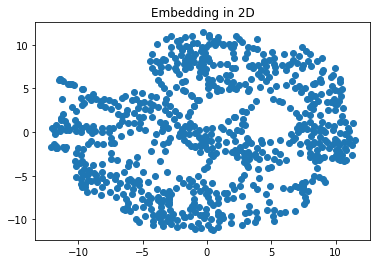

In [155]:
plt.scatter(embedding[:,0], embedding[:,1])
plt.title('Embedding in 2D')
plt.show()

# Supplementary Code that is not needed but might be useful again

In [60]:
print('run Poisson surface reconstruction')
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pointcloud, depth=9)
print(mesh)
o3d.visualization.draw_geometries([mesh],
                                  zoom=0.664,
                                  front=[-0.4761, -0.4698, -0.7434],
                                  lookat=[0.2, 0.2, 0.2],
                                  up=[0.2304, -0.8825, 0.4101])

run Poisson surface reconstruction
[Open3D DEBUG] Input Points / Samples: 7168 / 7168
[Open3D DEBUG] #   Got kernel density: 0.036 (s), 202.016 (MB) / 202.016 (MB) / 391 (MB)
[Open3D DEBUG] #     Got normal field: 0.0139999 (s), 206.133 (MB) / 206.133 (MB) / 391 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 3.476273e-04 / 2.491793e+00
[Open3D DEBUG] #       Finalized tree: 0.0359998 (s), 213.684 (MB) / 213.684 (MB) / 391 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0630002 (s), 205.664 (MB) / 213.684 (MB) / 391 (MB)
[Open3D DEBUG] #Set point constraints: 0.00999999 (s), 205.633 (MB) / 213.684 (MB) / 391 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 318151 / 147240 / 216361
[Open3D DEBUG] Memory Usage: 205.633 MB
[Open3D DEBUG] # Linear system solved: 0.136 (s), 209.879 (MB) / 213.684 (MB) / 391 (MB)
[Open3D DEBUG] Got average: 0.00400019 (s), 205.012 (MB) / 213.684 (MB) / 391 (MB)
[Open3D DEBUG] Iso-Value: 5.079764e-01 = 3.641174e+03 / 7.168000e+03
[Open3D DEBUG] #

In [ ]:
def extract_geodesic_patch(coords, normals, center_index, radius):

    cluster_point_idx = [center_index] # to save all the points that are within the geodesic radius
    
    #loop through all the points and check what their distance to the selected center point is
    for index, point in enumerate(coords):
        dist = np.linalg.norm(coords[center_index]-point)

        # select only those points that are close to the center point and calculate their geodesic distance
        if dist < radius and dist != 0:
            #dij = dist+((1-np.dot(normals[index], center_norm))*dist)
            dij = dist*(2-np.dot(normals[index], center_norm))# approximation of geodesic distance

            # select only those points that are *geodesically* close to the center point
            if dij < radius:
                cluster_point_idx.append(index)
    
    return cluster_point_idx

In [ ]:
def extract_geodesic_patch(coords, normals, center_index, radius):
    
    first_sel = [] #save indeces of first selection
    cluster = [center_index] #save indeces of cluster-members
    geod_distances_from_center = {center_index:0} #save geodesic distances to the center of cluster-members
    
    #loop through all the points and check what their distance to the selected center point is < radius
    for index, point in enumerate(coords):
        dist = np.linalg.norm(coords[center_index]-point)

        # select only those points that are close to the center point (non-geodesically)
        if dist < radius and dist != 0:
            first_sel.append(index)

            
    while len(first_sel) != 0:
        
        # find the point in first_sel, which is closest to any point in the cluster
        shortest_dist = 10^6
        closest_in_sel = 10^6
        closest_in_cluster = 10^6

        # compare each element in first_sel with each element in cluster and approximate their geodesic distance
        for sel in first_sel:
            for point in cluster:
                geo_dist = np.linalg.norm(coords[sel]-coords[point])*(2-np.dot(normals[sel], normals[point]))
                if geo_dist < shortest_dist:
                    closest_in_sel = sel
                    closest_in_cluster = point
                    shortest_dist = geo_dist

        # check if the found closest point should be part of the cluster
        dist_from_center = geod_distances_from_center[closest_in_cluster] + shortest_dist
        if dist_from_center < radius:
            # if yes, append its index to cluster, save its geod_dist_from_center and remove it from first_sel
            cluster.append(closest_in_sel)
            geod_distances_from_center[closest_in_sel]=dist_from_center
            first_sel.remove(closest_in_sel)
        else:
            first_sel.remove(closest_in_sel)
    
    return cluster     

In [ ]:
cluster_point_idx = extract_geodesic_patch(coords, normals, center, radius)

In [ ]:
#np.save("cluster_indeces.npy", cluster_point_idx)